In [1]:
import itertools

import numpy as np

import matplotlib.pyplot as plt

In [2]:
STUDENT_NUM = 810199089

# allowed actions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

ACTIONS = [LEFT,DOWN,RIGHT,UP]
ACTIONS_NAMES = ["←","↓","→","↑"]

In [3]:
from env import NSFrozenLake

environment = NSFrozenLake(studentNum=STUDENT_NUM)
environment.render()


------------------------------
| 0.000 | 0.862 | 0.493 | 0.695 | 
------------------------------
| 0.001 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.476 | 0.803 | 0.795 | 0.001 | 
------------------------------
| 0.893 | 0.822 | 0.248 | 0.000 | 
------------------------------


In [4]:
# hyperparameters
DISCOUNT = 0.9

### 1. Model-Based

In [5]:
def plot_policy(policy):
    out = ""
    for i in range(4):
        out += "\n-----------------\n| "
        for j in range(4):
            if (i,j)!=(3,3):
                out += "{D} | ".format(D=ACTIONS_NAMES[np.argmax(policy[i, j])])
            else:
                out += "* | "

    out += "\n-----------------"
    print(out)

In [6]:
# hyperparameters
DISCOUNT = 0.9

# init
Qs = np.zeros((4, 4, 4))

# policy evaluation (e.g. random policy)
delta = np.inf
while delta>0.01:
    delta=0
    for s in itertools.product(range(4), range(4)):
        # Q-value for goal state dosen't update
        if (s[0],s[1]) == (3,3):
            continue
        
        for a in ACTIONS:
            temp=Qs[s[0], s[1], a]
            states, probs, fail_probs, dones = environment.possible_consequences(action=a ,state_now=(s[0],s[1]))

            l = []
            for idx,sp in enumerate(states):
                prob=probs[idx]
                fail_prob=fail_probs[idx]
                is_terminal=dones[idx]

                reward = -1 + fail_prob*-10 + is_terminal*50
                l.append(prob*(reward+DISCOUNT*np.max(Qs[sp[0], sp[1]])))

            Qs[s[0], s[1], a]=np.sum(l)
            delta=np.max([delta, np.abs(temp-Qs[s[0], s[1], a])])

# policy imporvement
optimal_policy=np.zeros((4, 4, 4))
for s in itertools.product(range(4), range(4)):
    optimal_policy[s[0],s[1], np.argmax(Qs[s[0],s[1]])]=1

In [7]:
plot_policy(optimal_policy)


-----------------
| ↓ | ↓ | ↓ | ↓ | 
-----------------
| → | → | → | ↓ | 
-----------------
| ↑ | → | → | ↓ | 
-----------------
| → | → | → | * | 
-----------------


In [8]:
crs = []
for _ in range(10000):
    environment.reset()
    s = (0, 0)
    episode = []
    done = False

    while not done:
        a = np.random.choice(ACTIONS, 1, p=optimal_policy[s])[0]
        sp, r, done, _ = environment.step(a)
        s = sp
        episode.append((s, a, r))
    
    total_reward = np.sum([step[2] for step in episode])
    crs.append(total_reward)

In [9]:
cr_optimal = np.mean(crs)
print('Optimal Cumulative Reward: %.2f' % cr_optimal)

Optimal Cumulative Reward: 34.55


### 2. Model-Free

#### 2.1. Off-Policy MC

In [83]:
from amalearn.agent import AgentBase

class OffPolicyMCAgent(AgentBase):
    def __init__(self, environment, ep_func, discount):
        super(OffPolicyMCAgent, self).__init__("OffPolicyMCAgent", environment)
        self.ep_func = ep_func
        self.epsilon = self.ep_func(1)
        self.discount = discount

        '''
        Initialize, for all s∈S, a∈A(s):
            Q(s, a) ← arbitrary
            C(s, a) ← 0
            π(s) ← argmax_a Q(s,a) (with ties broken consistently)
        '''
        # init
        self.Qs = np.random.rand(4, 4, 4)
        self.Cs = np.zeros((4, 4, 4))

        # bahavior policy (e-greedy w.r.t. Qs)
        self.b = np.full((4, 4, 4), self.epsilon/4.0)
        for x in range(4):
            for y in range(4):
                self.b[x, y, np.argmax(self.Qs[x, y])] += 1-self.epsilon
        
        # evaluation policy (greedy w.r.t. Qs)
        self.pi = np.zeros((4, 4, 4))
        for x in range(4):
            for y in range(4):
                self.pi[x, y, np.argmax(self.Qs[x, y])] = 1

    def take_action(self):
        s = self.environment.state
        a = np.random.choice(ACTIONS, 1, p=self.b[s])[0]
        sp, r, done, _ = self.environment.step(a)
        return (sp, r, done, {'s': s, 'a': a})

    def update_Qs(self, episode):
        '''
        Performs MC control using episode list [S0, A0, R1, ..., ST-1, AT-1, RT, ST]
        G ← 0
        W ← 1
        For t = T-1, T-2, . . . down to 0:
            G ← γ*G + R_t+1
            C(St, At ) ← C(St,At ) + W
            Q(St, At ) ← Q(St,At) + (W/C(St,At))*[G-Q(St,At )]
            π(St) ← argmax_a Q(St,a) (with ties broken consistently)
            If At != π(St) then exit For loop
            W ← W * (1/b(At|St))        
        '''
        G = 0.0
        W = 1.0
        for (s, a, r) in reversed(episode):
            G = self.discount*G + r
            self.Cs[s][a] = self.Cs[s][a] + W
            self.Qs[s][a] = self.Qs[s][a] + (W/self.Cs[s][a]) * (G-self.Qs[s][a])

            # update evaluation policy (greedification w.r.t. Qs for state=s)
            self.pi[s] = np.zeros(4)
            self.pi[s][np.argmax(self.Qs[s])] = 1

            if a!=np.argmax(self.pi[s]):
                break

            W /= (1/self.b[s][a])

        # # update bahavior policy (e-greedy w.r.t. Qs)
        self.b = np.full((4, 4, 4), self.epsilon/4.0)
        for x in range(4):
            for y in range(4):
                self.b[x, y, np.argmax(self.Qs[x, y])] += 1-self.epsilon

        total_reward = np.sum([step[2] for step in episode])
        return total_reward

    def decay_epsilon(self, eps):
        self.epsilon = self.ep_func(eps+1)

In [84]:
def generate_episode(agent):
    episode = []
    done = False

    while not done:
        _, r, done, info = agent.take_action()
        episode.append((info['s'], info['a'], r))
    
    return episode

##### Constant vs Decay Epsilon

In [85]:
# hyperparameters
REPS = 20
EPISODES = 4000

In [86]:
# hyperparameters
EPSILON = 0.25

In [24]:
cr_opmc_no_decay = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    environment.reset()
    agent = OffPolicyMCAgent(environment, lambda _: EPSILON, DISCOUNT)
    for eps in range(1, EPISODES+1):
        environment.reset()
        episode = generate_episode(agent)
        cr_opmc_no_decay[rep, eps-1] = agent.update_Qs(episode)
        agent.decay_epsilon(eps) # do nothing

In [87]:
cr_opmc_decay = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    environment.reset()
    agent = OffPolicyMCAgent(environment, lambda eps: 0.75*(1-1e-3)**eps , DISCOUNT)
    for eps in range(1, EPISODES+1):
        environment.reset()
        episode = generate_episode(agent)
        cr_opmc_decay[rep, eps-1] = agent.update_Qs(episode)
        agent.decay_epsilon(eps)

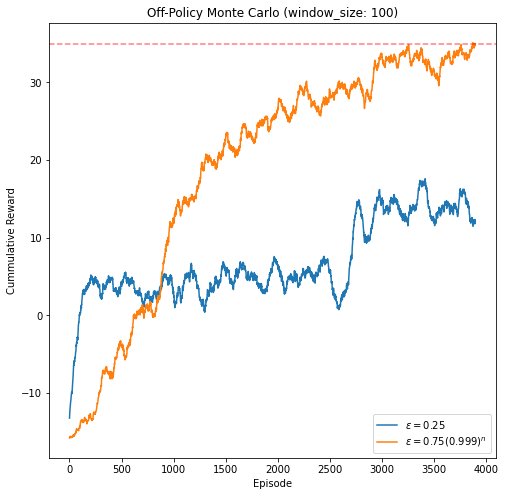

In [26]:
plt.figure(figsize=(8,8))

plt.title('Off-Policy Monte Carlo (window_size: 100)')
plt.plot(np.convolve(np.mean(cr_opmc_no_decay, axis=0), np.ones(100)/100, mode='valid'), label='$\epsilon=0.25$')
plt.plot(np.convolve(np.mean(cr_opmc_decay, axis=0), np.ones(100)/100, mode='valid'), label='$\epsilon=0.75(0.999)^{n}$')
plt.axhline(y=cr_optimal, ls='--', c='r', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Cummulative Reward')
plt.legend()

plt.show()

#### 2.2. Q-Learing (Off-Policy TD)

In [101]:
from amalearn.agent import AgentBase

class QLearningAgent(AgentBase):
    def __init__(self, environment, ep_func, lr_func, discount):
        super(QLearningAgent, self).__init__("QLearningAgent", environment)
        self.ep_func = ep_func
        self.epsilon = self.ep_func(1)
        self.lr_func = lr_func
        self.learning_rate = self.lr_func(1)
        self.discount = discount

        '''
        Initialize, for all s∈S, a∈A(s):
            Q(s, a) ← arbitrary
            Q(TERMINAL, a) ← 0
        '''
        # init
        self.Qs = np.random.rand(4, 4, 4)
        self.Qs[(3, 3)] = np.zeros(4)

        # bahavior policy (e-greedy w.r.t. Qs)
        self.b = np.full((4, 4, 4), self.epsilon/4.0)
        for x in range(4):
            for y in range(4):
                self.b[x, y, np.argmax(self.Qs[x, y])] += 1-self.epsilon

    def take_action(self):
        s = self.environment.state
        a = np.random.choice(ACTIONS, 1, p=self.b[s])[0]
        sp, r, done, _ = self.environment.step(a)
        return (sp, r, done, {'s': s, 'a': a})

    def update_Q(self, s, a, r, sp):
        '''
        Q(S,A) ← Q(S,A) + α[R+γ*max_a Q(Sp,a)-Q(S,A)]
        '''
        td_error = r+self.discount*np.max(self.Qs[sp]) - self.Qs[s][a]
        self.Qs[s][a] = self.Qs[s][a] + self.learning_rate*td_error
        
        # update bahavior policy (e-greedy w.r.t. Qs)
        self.b[s] = np.full(4, self.epsilon/4.0)
        self.b[s][np.argmax(self.Qs[s])] += 1-self.epsilon

    def decay_epsilon(self, eps):
        self.epsilon = self.ep_func(eps+1)

    def decay_learning_rate(self, eps):
        self.learning_rate = self.lr_func(eps+1)


##### Constant vs Decay Learning Rate

In [102]:
# hyperparameters
REPS = 20
EPISODES = 4000

In [103]:
# hyperparameters
LEARNING_RATE = 0.5

In [116]:
cr_q_no_decay = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    environment.reset()
    agent = QLearningAgent(environment, lambda eps: 0.75*(1-1e-3)**eps, lambda _: LEARNING_RATE, DISCOUNT)
    for eps in range(1, EPISODES+1):
        environment.reset()
        
        done = False
        rewards = []
        while not done:
            sp, r, done, info = agent.take_action()
            agent.update_Q(info['s'], info['a'], r, sp)
            rewards.append(r)
        
        agent.decay_epsilon(eps)
        cr_q_no_decay[rep][eps-1]=np.sum(rewards)

In [105]:
cr_q_decay = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    environment.reset()
    agent = QLearningAgent(environment, lambda eps: 0.75*(1-1e-3)**eps, lambda eps : 1/np.sqrt(eps), DISCOUNT)
    for eps in range(1, EPISODES+1):
        environment.reset()
        
        done = False
        rewards = []
        while not done:
            sp, r, done, info = agent.take_action()
            agent.update_Q(info['s'], info['a'], r, sp)
            rewards.append(r)

        agent.decay_epsilon(eps)
        agent.decay_learning_rate(eps)
        cr_q_decay[rep][eps-1]=np.sum(rewards)

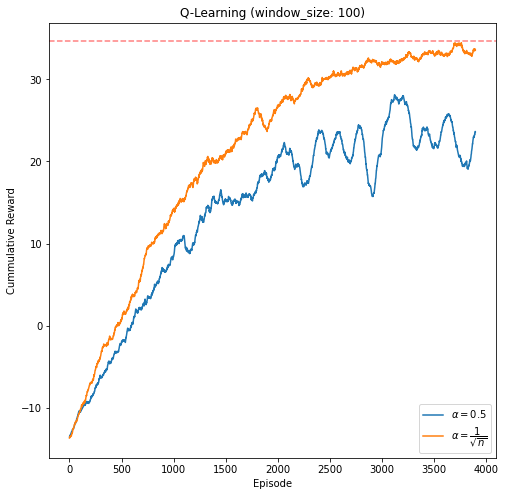

In [80]:
plt.figure(figsize=(8,8))

plt.title('Q-Learning (window_size: 100)')
plt.plot(np.convolve(np.mean(cr_q_no_decay, axis=0), np.ones(100)/100, mode='valid'), label='$α=0.5$')
plt.plot(np.convolve(np.mean(cr_q_decay, axis=0), np.ones(100)/100, mode='valid'), label='$α=\dfrac{1}{\sqrt{n}}$')
plt.axhline(y=cr_optimal, ls='--', c='r', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Cummulative Reward')
plt.legend()

plt.show()

#### 2.3

##### SARSA (On-Policy TD)

In [63]:
class SARSAAgent(AgentBase):
    def __init__(self, environment, ep_func, lr_func, discount):
        super(SARSAAgent, self).__init__("SARSAAgent", environment)
        self.ep_func = ep_func
        self.epsilon = self.ep_func(1)
        self.lr_func = lr_func
        self.learning_rate = self.lr_func(1)
        self.discount = discount

        '''
        Initialize, for all s∈S, a∈A(s):
            Q(s, a) ← arbitrary
            Q(TERMINAL, a) ← 0
        '''
        # init
        self.Qs = np.random.rand(4, 4, 4)
        self.Qs[(3, 3)] = np.zeros(4)

        # policy (e-greedy w.r.t. Qs)
        self.policy = np.full((4, 4, 4), self.epsilon/4.0)
        for x in range(4):
            for y in range(4):
                self.policy[x, y, np.argmax(self.Qs[x, y])] += 1-self.epsilon

    def take_action(self):
        s = self.environment.state
        a = np.random.choice(ACTIONS, 1, p=self.policy[s])[0]
        sp, r, done, _ = self.environment.step(a)
        return (sp, r, done, {'s': s, 'a': a})

    def choose_action(self):
        s = self.environment.state
        a = np.random.choice(ACTIONS, 1, p=self.policy[s])[0]
        return a

    def update_Q(self, s, a, r, sp, ap):
        '''
        Q(S,A) ← Q(S,A) + α[R+γ*Q(Sp,Ap)-Q(S,A)]
        '''
        td_error = r+self.discount*self.Qs[sp][ap] - self.Qs[s][a]
        self.Qs[s][a] = self.Qs[s][a] + self.learning_rate*td_error
        
        # update policy (e-greedy w.r.t. Qs)
        self.policy[s] = np.full(4, self.epsilon/4.0)
        self.policy[s][np.argmax(self.Qs[s])] += 1-self.epsilon

    def decay_epsilon(self, eps):
        self.epsilon = self.ep_func(eps+1)

    def decay_learning_rate(self, eps):
        self.learning_rate = self.lr_func(eps+1)

In [64]:
# hyperparameters
REPS = 20
EPISODES = 4000

In [65]:
cr_sarsa = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    environment.reset()
    agent = SARSAAgent(environment, lambda eps: 0.75*(1-1e-3)**eps, lambda eps : 1/np.sqrt(eps), DISCOUNT)
    for eps in range(1, EPISODES+1):
        environment.reset()

        rewards = []
        s = (0, 0)
        done = False
        a = agent.choose_action()
        while not done:
            sp, r, done, _ = environment.step(a)
            ap = agent.choose_action()
            agent.update_Q(s, a, r, sp, ap)
            s = sp
            a = ap
            rewards.append(r)

        agent.decay_epsilon(eps)
        agent.decay_learning_rate(eps)
        
        cr_sarsa[rep][eps-1]=np.sum(rewards)

##### N-Step Tree Backup

In [66]:
class NStepTreeBackup(AgentBase):
    def __init__(self, environment, N, ep_func, lr_func, discount):
        super(NStepTreeBackup, self).__init__("NStepTreeBackup", environment)
        self.N = N
        self.cnt = 0
        self.ep_func = ep_func
        self.epsilon = self.ep_func(1)
        self.lr_func = lr_func
        self.learning_rate = self.lr_func(1)
        self.discount = discount

        '''
        Initialize, for all s∈S, a∈A(s):
            Q(s, a) ← arbitrary
            Q(TERMINAL, a) ← 0
        '''
        # init
        self.Qs = np.random.rand(4, 4, 4)
        self.Qs[(3, 3)] = np.zeros(4)

        # b (e-greedy w.r.t. Qs)
        self.b = np.full((4, 4, 4), self.epsilon/4.0)
        for x in range(4):
            for y in range(4):
                self.b[x, y, np.argmax(self.Qs[x, y])] += 1-self.epsilon

        # pi (greedy w.r.t. Qs)
        self.pi = np.zeros((4, 4, 4))
        for x in range(4):
            for y in range(4):
                self.pi[x, y, np.argmax(self.Qs[x, y])] = 1

    def take_steps(self, s):
        G = 0
        if self.cnt<self.N:
            self.cnt += 1
            a = np.random.choice(ACTIONS, 1, p=self.b[s])[0]
            self.environment.render()
            sp, r, done, _ = self.environment.step(a)
            print(s, ACTIONS_NAMES[a], r, sp, done)
            G += r
            if not done:
                G += self.discount*np.sum(np.delete(self.pi[sp], a)*np.delete(self.Qs[sp], a))
                G += self.discount*self.pi[sp][a]*self.take_steps(sp)
            else:
                self.cnt = 0
                G += self.discount*np.sum(self.pi[sp][a]*self.Qs[sp][a])
            
            return G
        else:
            self.cnt = 0
            return G

    def choose_action(self, s):
        a = np.random.choice(ACTIONS, 1, p=self.b[s])[0]
        return a

    def update_Q(self, s, a, G):
        '''
        Q(S,A) ← Q(S,A) + α[G-Q(S,A)]
        '''
        td_error = G - self.Qs[s][a]
        self.Qs[s][a] = self.Qs[s][a] + self.learning_rate*td_error
        
        # update bahavior policy (e-greedy w.r.t. Qs)
        self.b[s] = np.full(4, self.epsilon/4.0)
        self.b[s][np.argmax(self.Qs[s])] += 1-self.epsilon

        # update evaluation policy (greedy w.r.t. Qs)
        self.pi[s] = np.zeros(4)
        self.pi[s][np.argmax(self.Qs[s])] = 1

    def decay_epsilon(self, eps):
        self.epsilon = self.ep_func(eps+1)

    def decay_learning_rate(self, eps):
        self.learning_rate = self.lr_func(eps+1)

In [67]:
# hyperparameters
REPS = 20
EPISODES = 4000

In [68]:
# hyperparameters
N = 2

In [69]:
# 
cr_n_step = np.zeros((REPS, EPISODES))
for rep in range(REPS):
    environment.reset()
    agent = NStepTreeBackup(environment, N, lambda eps: 0.75*(1-1e-3)**eps, lambda eps : 1/np.sqrt(eps), DISCOUNT)
    for eps in range(1, EPISODES+1):
        environment.reset()
        # init s0, a0, r0
        states = [(0, 0)]
        actions = [agent.choose_action(states[0])]
        rewards = [np.nan]

        T = np.inf
        t = 0
        while(True):
            if t<T:
                sp, r, done, _ = environment.step(actions[t])
                states.append(sp)
                rewards.append(r)
                if done:
                    T = t+1
                else:
                    ap = agent.choose_action(states[t+1])
                    actions.append(ap)

            # tau is the time whose estimate is being updated
            tau = t+1-N
            if tau>=0:
                discount = agent.discount
                Qs = agent.Qs
                pi = agent.pi

                G = 0
                if t+1>=T:
                    G = rewards[T]
                else:
                    G = rewards[t+1] + discount*np.sum(pi[states[t+1]]*Qs[states[t+1]])
                for k in reversed(range(tau+1, min(t, T-1))):
                    G = rewards[k] 
                    + discount*np.sum(np.delete(pi[states[k]], actions[k])*np.delete(Qs[states[k]], actions[k])) 
                    + discount*pi[states[k]][actions[k]]*G
                
                # update Q
                agent.update_Q(states[tau], actions[tau], G)

            if tau==T-1:
                break
            t += 1
        
        agent.decay_epsilon(eps)
        agent.decay_learning_rate(eps)
        
        cr_n_step[rep][eps-1]=np.sum(rewards[1:])

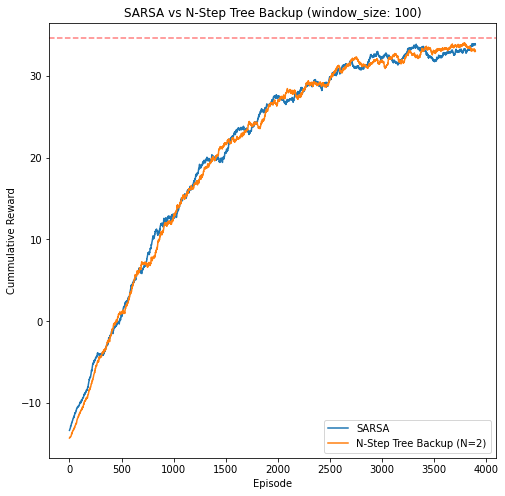

In [74]:
plt.figure(figsize=(8,8))

plt.title('SARSA vs N-Step Tree Backup (window_size: 100)')
plt.plot(np.convolve(np.mean(cr_sarsa, axis=0), np.ones(100)/100, mode='valid'), label='SARSA')
plt.plot(np.convolve(np.mean(cr_n_step, axis=0), np.ones(100)/100, mode='valid'), label='N-Step Tree Backup (N=2)')
plt.axhline(y=cr_optimal, ls='--', c='r', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Cummulative Reward')
plt.legend()

plt.show()

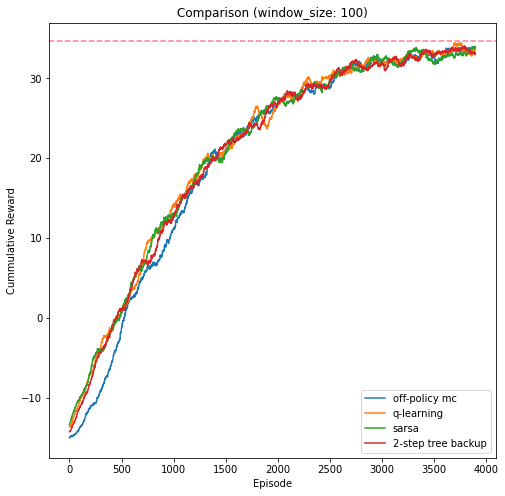

In [88]:
plt.figure(figsize=(8,8))

plt.title('Comparison (window_size: 100)')
plt.plot(np.convolve(np.mean(cr_opmc_decay, axis=0), np.ones(100)/100, mode='valid'), label='off-policy mc')
plt.plot(np.convolve(np.mean(cr_q_decay, axis=0), np.ones(100)/100, mode='valid'), label='q-learning')
plt.plot(np.convolve(np.mean(cr_sarsa, axis=0), np.ones(100)/100, mode='valid'), label='sarsa')
plt.plot(np.convolve(np.mean(cr_n_step, axis=0), np.ones(100)/100, mode='valid'), label='2-step tree backup')
plt.axhline(y=cr_optimal, ls='--', c='r', alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Cummulative Reward')
plt.legend()

plt.show()